In [2]:
import os
from datasets import load_dataset
import sqlite3
import pandas as pd
import torch
import json
from transformers import RobertaTokenizer
from modules.models import CodeBertJS,CodeT5
from modules.datasets import CodeBertDataset
from modules.metrics import CodeRouge
from torch.utils.data import DataLoader

# SQLITE_PATH = input("Paste sqlite3 path: ")
# MODEL_NAME = input("Paste Model Name: ")
# VERSION = int(input("Paste model version: "))
# CPKT_PATH = input('Paste cpkt path: ')
# METRICS_PATH = input('Paste metris dir path: ')
# HF_DIR = input('Paste hf model dir')
# MAX_LENGTH = int(input("Paste tokenizer max length: "))

SQLITE_PATH =  'humanevalpack.db'
MODEL_NAME = 'CodeBertJS_unfiltered'
VERSION = 3
CPKT_PATH = 'checkpoints/CodeBertJS_unfiltered_v1.ckpt'
METRICS_PATH = 'metrics'
HF_DIR = 'microsoft/codebert-base-mlm'
MAX_LENGTH = 450

In [3]:
if os.path.exists(SQLITE_PATH):
    con = sqlite3.connect(SQLITE_PATH)
    ds_df = pd.read_sql_query("SELECT * FROM humanevalpack", con).set_index('index')
else:
    ds = load_dataset(
        'bigcode/humanevalpack',
        'js',
    )
    ds_list = []
    for row in ds.get('test'):
        ds_list.append(row)
    ds_df = pd.DataFrame(ds_list)
    con = sqlite3.connect(SQLITE_PATH)
    ds_df.to_sql('humanevalpack',con)


In [5]:
if MODEL_NAME == 'T5JSRephraser':
    model = CodeT5.load_from_checkpoint(CPKT_PATH)
elif 'CodeBertJS' in MODEL_NAME:
    model = CodeBertJS.load_from_checkpoint(CPKT_PATH)
    
if model.device != 'cpu':
    model.to('cpu')

model.mode = 'test'

Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tokenizer = RobertaTokenizer.from_pretrained(HF_DIR)
encoded_samples = tokenizer(
    ds_df['buggy_solution'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = tokenizer(
    ds_df['canonical_solution'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

In [8]:
torch_ds = CodeBertDataset(encoded_samples, encoded_labels.input_ids)
loader = DataLoader(torch_ds, batch_size=1)

generated_codes = []
for batch in iter(loader):
    out = model.forward(**batch)
    decoded_out = torch.argmax(out[1], dim=-1)
    generated_codes.append(tokenizer.batch_decode(decoded_out, skip_special_tokens=True)[0])
    
references = ds_df['canonical_solution'].tolist()

if(len(generated_codes) != len(references)):
    raise ValueError("Invalid model output.")

In [10]:
rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=generated_codes, references=references)
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}.csv"
with open(avgs_path, 'w') as f:
    json.dump(rouge.avgs, f)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index='table')

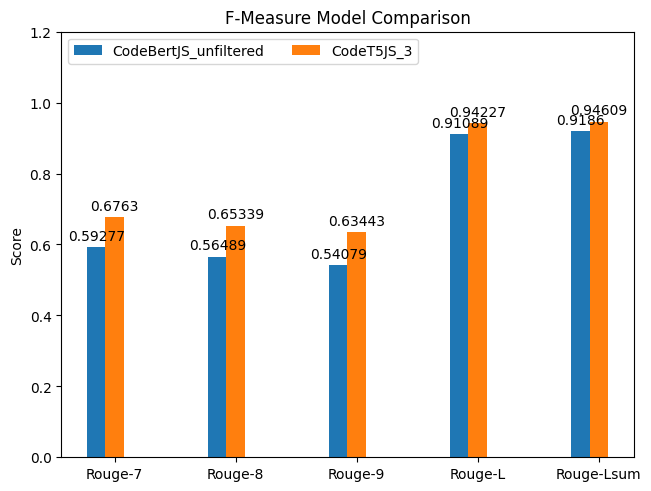

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs

comparison_model_path = '/content/drive/MyDrive/Thesis/metrics/CodeT5JS_3.json'
if not os.path.exists(comparison_model_path):
    comparison_model_path = 'metrics/CodeT5JS_3.json'

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)
    

plot_data = {
    MODEL_NAME: (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    'CodeT5JS_3': (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')

for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.show()